In [11]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import os
tf.keras.mixed_precision.set_global_policy("float32")
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
root_dir = r"C:\Users\jorda\Documents"
def load_data(path):
    train_files = []
    train_loc = os.path.join(path, "\keras_png_slices_data\keras_png_slices_train")
    for filename in os.listdir(train_loc):
        train_files.append(os.path.join(train_loc, filename))

    test_files = []
    test_loc = os.path.join(path, "\keras_png_slices_data\keras_png_slices_test")
    for filename in os.listdir(test_loc):
        test_files.append(os.path.join(test_loc, filename))

    val_files = []
    val_loc = os.path.join(path, "\keras_png_slices_data\keras_png_slices_validate")
    for filename in os.listdir(val_loc):
        val_files.append(os.path.join(val_loc, filename))        
    
    return train_files, test_files, val_files
        


In [13]:
from random import shuffle


root_dir = r"C:\Users\jorda\Documents"
directories = ["keras_png_slices_data\keras_png_slices_test",
            "keras_png_slices_data\keras_png_slices_train",
            "keras_png_slices_data\keras_png_slices_validate"]
def load_data2(path, directories, batches):
    test_imgs = keras.utils.image_dataset_from_directory(os.path.join(path, directories[0]),
                                                        color_mode='grayscale',
                                                        label_mode = None,
                                                        batch_size=batches,
                                                        image_size=(256, 256))       

    train_imgs = keras.utils.image_dataset_from_directory(os.path.join(path, directories[1]),
                                                        color_mode='grayscale',
                                                        label_mode = None,
                                                        batch_size=batches,
                                                        image_size=(256, 256))       

    # val_imgs = keras.utils.image_dataset_from_directory(os.path.join(path, directories[2]),
    #                                                     color_mode='grayscale',
    #                                                     label_mode = None,
    #                                                     batch_size=batches,
    #                                                     image_size=(256, 256))       
    # print(type(test_imgs))
    
    # test_imgs = test_imgs.map(scale_down, num_parallel_calls=tf.data.AUTOTUNE)
    # train_imgs = train_imgs.map(scale_down, num_parallel_calls=tf.data.AUTOTUNE)
    # val_imgs = val_imgs.map(scale_down, num_parallel_calls=tf.data.AUTOTUNE)
    # var = tfp.stats.variance(test_imgs)
    # print("variance is ", var)
    return test_imgs, train_imgs

# def scale_down(image):
#     return image/255

test_imgs, train_imgs = load_data2(root_dir, directories, None)

train_np = np.stack(list(train_imgs))
test_np = np.stack(list(test_imgs))
# train_np = np.expand_dims(train_np, -1)
# test_np = np.expand_dims(test_np, -1)
# normalise
train_np = train_np/255
test_np = test_np/255

var = np.var(train_np)
# print(var)
# # test_var = tf.
# print(type(test_imgs))

# print(type(train_np), train_np.shape)
# print(type(test_np), test_np.shape)

Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.


In [14]:
# Generate the VQ layer to quantise encoder output
# Based on official keras documentation: https://keras.io/examples/generative/vq_vae/

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
                                        initial_value=w_init(
                                        shape=(self.embedding_dim, self.num_embeddings), dtype="float32"),
                                        trainable=True,
                                        name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [15]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(256, 256, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    # x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    # x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


In [16]:
def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    # x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    # x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [17]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    # vq_layer.summary()
    encoder = get_encoder(latent_dim)
    encoder.summary()
    decoder = get_decoder(latent_dim)
    decoder.summary()
    inputs = keras.Input(shape=(256, 256, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 16)        1040      
                                                                 
Total params: 19,856
Trainable params: 19,856
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 6

In [18]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [19]:
vqvae_trainer = VQVAETrainer(var, latent_dim=16, num_embeddings=64)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(train_np, epochs=30, batch_size=16)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 16)        1040      
                                                                 
Total params: 19,856
Trainable params: 19,856
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 6

1/1 [==============================] - 0s 164ms/step


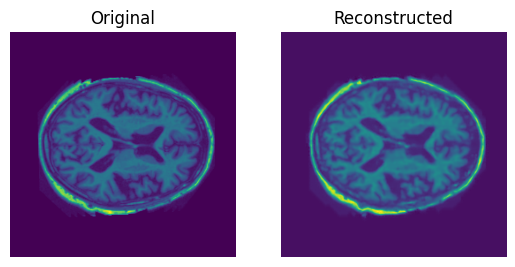

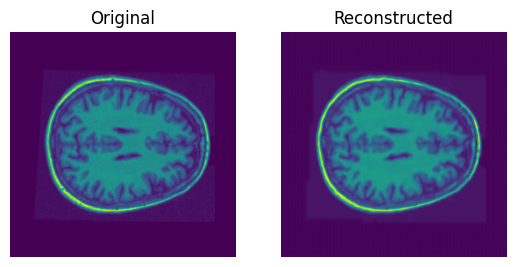

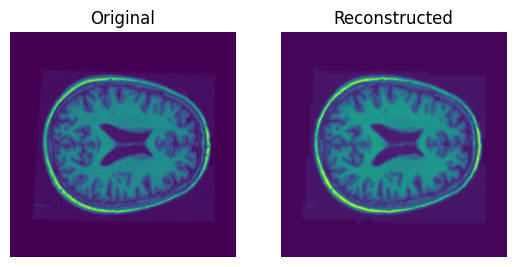

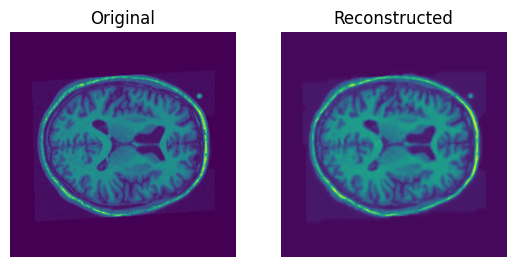

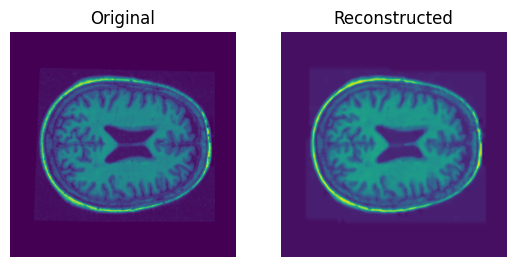

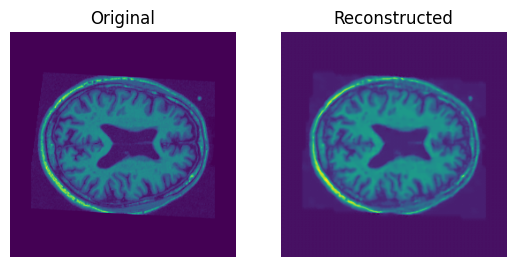

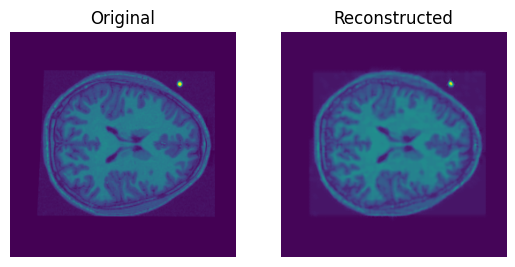

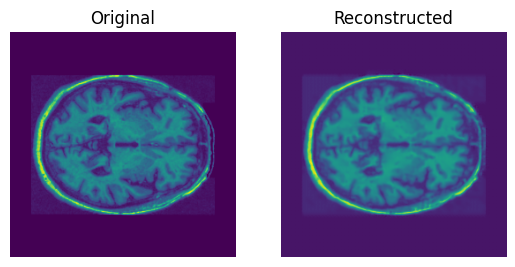

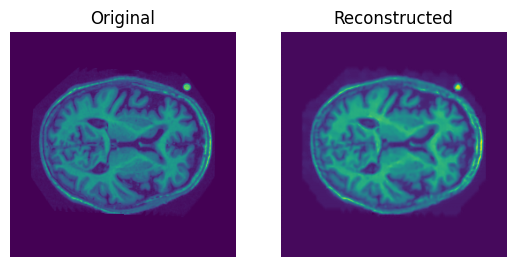

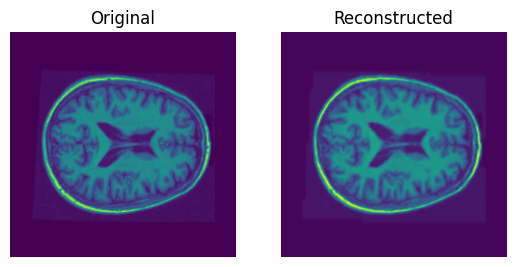

In [20]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(test_np), 10)
test_images = test_np[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)